In [1]:


# First import library
import pyrealsense2 as rs
# Import Numpy for easy array manipulation
import numpy as np
# Import OpenCV for easy image rendering
import cv2
# Import argparse for command-line options
# Import os.path for file path manipulation
import os.path


# Parse the command line arguments to an object
args = "C:/Users/gordon/Documents/board_a.bag"#ap  low_light
# Safety if no parameter have been given
if not args:
    print("No input paramater have been given.")
    print("For help type --  help")
    exit()
# Check if the given file have bag extension
if os.path.splitext(args)[1] != ".bag":
    print("The given file is not of correct file format.")
    print("Only .bag files are accepted")
    exit()
try:
    # Create pipeline
    pipeline = rs.pipeline()

    # Create a config object
    config = rs.config()

    
    # Tell config that we will use a recorded device from filem to be used by the pipeline through playback.
    rs.config.enable_device_from_file(config, args)
    # Configure the pipeline to stream the depth stream
   # config.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
   # config.enable_stream(rs.stream.color, 1280, 720, rs.format.rgb8, 30)



    # Start streaming from file
    pipeline.start(config)

    # Create opencv window to render image in
    cv2.namedWindow("Depth Stream", cv2.WINDOW_AUTOSIZE)
   # color_cvt = cv2.cvtColor(color_image,cv2.COLOR_RGB2BGR)    #convert color to correct
    cv2.namedWindow("Color Stream", cv2.WINDOW_AUTOSIZE)

    # Create colorizer object
    colorizer = rs.colorizer();
    tmp=[]
    # Streaming loop
    while True:
        # Get frameset of depth
        frames = pipeline.wait_for_frames()
       # aligned_frames = align.process(frames)
        # Get depth frame
        color_frame=frames.get_color_frame()
        align = rs.align(rs.stream.color)
        frames = align.process(frames)
        # Colorize depth frame to jet colormap
        depth_frame=frames.get_depth_frame()
        
        #print("depth: ",depth_frame.get_frame_number(),"color: ",color_frame.get_frame_number())
        depth_color_frame = colorizer.colorize(depth_frame)

        # Convert depth_frame to numpy array to render image in opencv
        depth_color_image = np.asanyarray(depth_color_frame.get_data())
        depth_gray_image = np.asanyarray(depth_frame.get_data())
        color_image=np.asanyarray(color_frame.get_data())
        gray=(depth_gray_image/3000*255).astype("uint8")
        tmp.append(np.asarray(depth_frame.get_data()).copy())
        # Render image in opencv window
        cv2.imshow("Depth Stream", depth_color_image)
        cv2.imshow("Color Stream",color_image)
    #cv2.imshow("Depth Stream", depth_color_image)
        key = cv2.waitKey(1)
        # if pressed escape exit program
        if key == 27:
            cv2.destroyAllWindows()
            break

finally:
    pass


In [ ]:
depth_gray_image.max()

In [2]:
# First import library
import pyrealsense2 as rs
# Import Numpy for easy array manipulation
import numpy as np
# Import OpenCV for easy image rendering
import cv2
# Import argparse for command-line options
# Import os.path for file path manipulation
import os.path
args = "C:/Users/gordon/Documents/board_c.bag"#ap



In [3]:
for i in range(100000):
    frames = pipeline.wait_for_frames()
    depth_frame = frames.get_depth_frame()
    print(depth_frame.get_frame_number())
    depth_gray_image = np.asanyarray(depth_frame.get_data())
    gray=(depth_gray_image/depth_gray_image.max()*255).astype(int)

NameError: name 'pipeline' is not defined

In [ ]:
cv2.destroyAllWindows()

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
a.get(0)

### start

In [2]:
import time
import matplotlib.pyplot as plt
# First import library
import pyrealsense2 as rs
# Import Numpy for easy array manipulation
import numpy as np
# Import OpenCV for easy image rendering
import cv2
# Import argparse for command-line options
# Import os.path for file path manipulation
import os.path
def finding_edge(frames):
    arr=np.asarray(frames)
    avg=non_zero_mean(frames)
    maxdiff=max_tolerant_diff(avg)
    noise=np.sum(np.logical_and(np.absolute(arr-avg)>maxdiff,arr!=0),axis=0)
    noise_rate=noise/len(frames)
    return noise_rate>0.2
def get_critiacal_frames(start,lower,upper,cframes):
    beforemask=1
    totallightup=0
    for i in range(30):
        nowmask=  cv2.inRange(cframes[i], lower, upper)/255
        totallightup+=(nowmask-beforemask>0)
        beforemask=nowmask
    avgmask=np.sum(totallightup)/30
    print("avg: ",avgmask)
    for i in range(max(start,30),len(cframes)):
        nowmask=  cv2.inRange(cframes[i], lower, upper)/255
        lightup=np.logical_and((nowmask-beforemask>0),np.average(cframes[i]-cframes[i-1],axis=2)>100)
        if(np.sum(lightup)>3*avgmask):  #need more check
            return i 
        beforemask=nowmask
    print("fail to find critical")
    return 0
def Hole_filling(arr):
    for i in range(1,len(arr)-1):
        mid0=arr[i]==0
        bef0=arr[i-1]==0
        aft0=arr[i+1]==0
        arr[i]=arr[i]+np.logical_and(np.logical_not(bef0),np.logical_not(aft0))*(bef0+aft0)*0.5
    return arr
def smoothing(frame):
    rleft=np.roll(frame,-1,axis=0)
    rrigth=np.roll(frame,1,axis=0)
    rup=np.roll(frame,1,axis=1)
    rdown=np.roll(frame,1,axis=1)
    total=frame+rleft+rrigth+rup+rdown
    return total/(1+(rleft!=0)+(rrigth!=0)+(rup!=0)+(rdown!=0))
def getbackground(dep):
    allframe=np.asarray(dep)
    allframe[allframe==0]=9999
    bg=np.sort(allframe,axis=0)[(int)(len(allframe)*0.85)]
    return bg   
def non_zero_mean(frames):
    arr=np.asarray(frames)
    avg=np.sum(arr,axis=0)/np.sum( arr!=0 ,axis=0)
    return np.nan_to_num(avg,0)
def to_real_xyz(yi,xi,d):
    x=-(xi/640-1.00078)*0.69243*d
    y=-(yi/360-1.00139)*0.38887*d
    z=d
    return  x,y,z
def max_tolerant_diff(depth):
    return 2.5*(depth*depth*0.000006+0.0002*depth-0.9789)
def savetopointcloud(file_name,depth_frame,color_frame,re=False):
    points=[]
    for y in range(depth_frame.shape[0]):
        for x in range(depth_frame.shape[1]):
            d=depth_frame[y,x]
            if(d==0):
                continue
            xyz=to_real_xyz(y,x,d)
            color=color_frame[y,x,:]
            if(re==False):
                points.append("%f %f %f %d %d %d\n"%(xyz+(color[2],color[1],color[0])))
            else:
                points.append(np.asarray((xyz+(color[0],color[1],color[2]))))
    if(re==True):                  
        return np.asarray(points)
    file=open(file_name,"w")
    file.write('''ply
format ascii 1.0
element vertex %d
property float x
property float y
property float z
property uchar blue
property uchar green
property uchar red
end_header
%s
'''%(len(points),"".join(points)))
    file.close()
def savepointtofile(p,file_name):
    points=[]
    for i in p:
        i=tuple(i)
        if(len(i)==3):
            i=i+(0,0,255)
        points.append("%f %f %f %d %d %d\n"%i)
    file=open(file_name,"w")
    file.write('''ply
format ascii 1.0
element vertex %d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
%s
'''%(len(points),"".join(points)))
    file.close()
def readallframes(path,start,maxframes,redepth,recolor):
    time.sleep(0.01)
    pipeline = rs.pipeline()
    config = rs.config()
    rs.config.enable_device_from_file(config, path)
    #align_to = rs.stream.color # or also depth
    #align = rs.align(align_to)
    
    framenumber=0
    # Start streaming from file
    pipeline.start(config)
    count=0
    frame_num=0
    i=0
    while True:
        frames = pipeline.wait_for_frames()
       
        # Get depth frame
        color_frame=frames.get_color_frame()
        align = rs.align(rs.stream.color)
        frames = align.process(frames)
        # Colorize depth frame to jet colormap
        depth_frame=frames.get_depth_frame()
        if(i>start):
            redepth.append(np.asarray(depth_frame.get_data()).copy())
            recolor.append(np.asarray(color_frame.get_data()).copy())
        i+=1
        if(depth_frame.get_frame_number()<frame_num):
            break
        else:
            frame_num=depth_frame.get_frame_number()
    
       # print("depth: ",depth_frame.get_frame_number(),"color: ",color_frame.get_frame_number())
        count+=1
        if(count>maxframes):
            break
   # return redepth,recolor


### first read in file

In [145]:
np.sort([2,7,4])

array([2, 4, 7])

In [3]:
red=[]
rec=[]
readallframes("C:/Users/gordon/Documents/1530mmbias.bag",0,1000,red,rec)
print(len(red),len(rec))
red[1]

172 172


array([[   0,    0,    0, ..., 1556, 1556, 1555],
       [   0,    0,    0, ..., 1553, 1553, 1553],
       [   0,    0,    0, ..., 1552, 1553, 1553],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint16)

In [15]:
for i in range(len(red)):
    red[i][:,0:100]=0

C:\Users\gordon\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


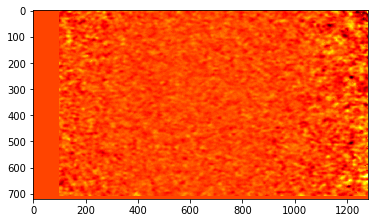

In [17]:
import matplotlib.pyplot as plt
plt.imshow((non_zero_mean(red[1:5])-non_zero_mean(red[6:11]))+10, cmap="hot", interpolation='nearest')#(non_zero_mean(red[1:5])-non_zero_mean(red[6:11]))+10
plt.show()

In [47]:
allvar=[]
xaxix=[1,2,3,4,5,7,9,11,14,17,20,25,30,50]
totalavg=non_zero_mean(red)
for k in xaxix:
    var=[]
    for i in range(5,150,max(k,6)):  
        var.append(np.mean(np.abs(non_zero_mean(red[i:i+k])-totalavg)))
    allvar.append(np.mean(var)


C:\Users\gordon\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


1 frames : var: 5.362285024864514
2 frames : var: 3.6618010115184654
3 frames : var: 2.922955823503428
4 frames : var: 2.500048468546892
5 frames : var: 2.2832414239061145
7 frames : var: 1.8733830608162216
9 frames : var: 1.6798413100048262
11 frames : var: 1.5289440072561293
14 frames : var: 1.3244497269964188
17 frames : var: 1.2021651960350357
20 frames : var: 1.0873020406873737
25 frames : var: 0.9708184750667943
30 frames : var: 0.8664493106652236
50 frames : var: 0.6294496249293089


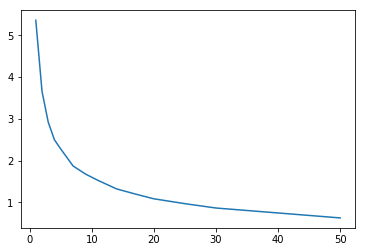

In [55]:
for i in range(len(xaxix)):
    print(str(xaxix[i])+" frames : var: "+str(allvar[i]))
plt.plot(xaxix,allvar) 

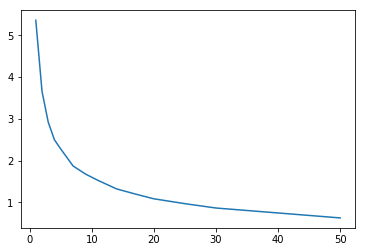

import  matplotlib.pyplot  as  plt
import statistics as st
p11=[]
p12=[]
p21=[]
p22=[]
for i in red:
    p11.append(i[240,480])
    p12.append(i[242,480])
    p21.append(i[240,482])
    p22.append(i[242,482])
fig, axs = plt.subplots(4)
axs[0].plot(p11)
axs[1].plot(p12)
axs[2].plot(p21)
axs[3].plot(p22)
print("std :",np.std(p11),np.std(p12),np.std(p21),np.std(p22))
print("mean  :"  ,np.mean(p11),np.mean(p12),np.mean(p21),np.mean(p22))

In [5]:
def PCA(data, correlation = False, sort = True):
    mean = np.mean(data, axis=0)
    data_adjust = data - mean
#: the data is transposed due to np.cov/corrcoef syntax
    if correlation:
        matrix = np.corrcoef(data_adjust.T)
    else:
        matrix = np.cov(data_adjust.T) 
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    if sort:
    #: sort eigenvalues and eigenvectors
        sort = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[sort]
        eigenvectors = eigenvectors[:,sort]
    return eigenvalues, eigenvectors
def best_fitting_plane(points):
    w, v = PCA(points)
#: the normal of the plane is the last eigenvector
    normal = v[:,2]
#: get a point from the plane
    point = np.mean(points, axis=0)
    
    a, b, c = normal
    d = -(np.dot(normal, point))
    return (point, normal , a, b, c, d)


C:\Users\gordon\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


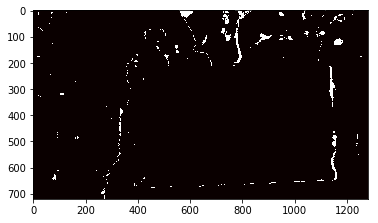

In [5]:

plt.imshow(finding_edge(red[0:30]), cmap="hot", interpolation='nearest')

In [11]:
savetopointcloud("low_light.ply",non_zero_mean(red[1:5]),rec[3])#np.mean(np.asarray(red)[5:105,:,:],axis=0)
      #  non_zero_mean(red[1:30])

C:\Users\gordon\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


In [5]:
def green_mask(cframe):
    newp=cframe*np.asarray([[[2,1,1]]])
    truecolor=np.asarray([[[0,1,0.65]]])
    mask=(np.sum((newp*truecolor),axis=2)/np.sqrt(np.sum(newp*newp,axis=2)*np.sum(truecolor*truecolor,axis=2)))>0.82
    mask2=(np.sum(cframe,axis=2)>150)
    return np.logical_and(mask,mask2).astype(np.uint8)
def red_mask(cframe):
    newp=cframe*np.asarray([[[1,0.8,0.8]]])
    truecolor=np.asarray([[[1,0.1,0.1]]])
    mask=(np.sum((newp*truecolor),axis=2)/np.sqrt(np.sum(newp*newp,axis=2)*np.sum(truecolor*truecolor,axis=2)))>0.9
    mask2=(np.sum(cframe,axis=2)>50)
    return np.logical_and(mask,mask2).astype(np.uint8)

p=rec[116]
lower=np.asarray([0,50,50])#need more check
upper=np.asarray([15,255,200])#need more check
mask =np.asarray([ cv2.inRange(p, lower, upper)])/255
mask=np.moveaxis(mask,0,-1)
img= (p*mask).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imshow('My Image ori',cv2.cvtColor(p, cv2.COLOR_RGB2BGR))
cv2.imshow('My Image mask',img)

# 按下任意鍵則關閉所有視窗
cv2.waitKey(0)
cv2.destroyAllWindows()

### second step : check finding critical frame & red dot &gplane

In [6]:
#critical=get_critiacal_frames(30,np.asarray([250,250,250]),np.asarray([255,255,255]),rec)
critical=23
p=rec[critical-5]
redstd=red[critical-7:critical-3]
mask =np.asarray([ red_mask(p)])+np.asarray([ green_mask(p)])
mask=(mask>0)
mask=np.moveaxis(mask,0,-1)
img= (p*mask).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imshow('My Image critical',cv2.cvtColor(rec[critical], cv2.COLOR_RGB2BGR))
cv2.imshow('My Image ori',cv2.cvtColor(rec[critical-2], cv2.COLOR_RGB2BGR))
cv2.imshow('My Image mask',img)

# 按下任意鍵則關閉所有視窗
cv2.waitKey(0)
cv2.destroyAllWindows()

In [45]:
critical

0

In [16]:
def show_img_gray(img):
    img = np.asarray(img>0,dtype=np.uint8)
    cv2.imshow('My Image mask',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [240]:
red[0][1,2]

2523

In [31]:

print("critical frame: ",get_critiacal_frames(0,np.asarray([245,245,245]),np.asarray([255,255,255]),rec) )     
    

avg:  543.9666666666667
critical frame:  118


### third check red dot finding

In [7]:
class Points():
    def __init__(self,inid=0,place=(),num=0):
        self.place=place
        self.num=num
        self.id=inid
    def add(self,i,j):
        self.place[0]+=i
        self.place[1]+=j
        self.num+=1
    def __lt__(self, other):
        return self.num<other.num
    def __gt__(self,other):
        return self.num>other.num
    def __ne__(self,other):
        return self.num!=other.num
    def __eq__(self,other):
       # print("in")
        return self.num==other.num
class Connect_component():
    def __init__(self,rdnum,gpnum):
        self.gp=[]
        self.rd=[]
        for i in range(rdnum+1):
            self.rd.append(Points())
        for i in range(gpnum+1):
            self.gp.append(Points())
    def addrd(self,rid,i,j):
        if(self.rd[rid]==Points()):
            #print("add rd")
            self.rd[rid]=Points(rid,[i,j],1)
        else :
            self.rd[rid].add(i,j)
    def addgp(self,gid,i,j):
        if(self.gp[gid]==Points()):
            self.gp[gid]=Points(gid,[i,j],1)
        else :
            #print("re")
            self.gp[gid].add(i,j)    


    def gplane(self):
        return max(self.gp)
    def rdot(self,gplane):
        self.rd.sort(reverse=True)
        re=[]
        for i in range(len(self.rd)):
            if(len(self.rd[i].place)==0):
                continue
            core=np.asarray(self.rd[i].place)/(self.rd[i].num)
            core=core.astype(int)
           # print(core)
            if(gplane[core[0],core[1]]!=0 and self.rd[i].num>5):
                re.append(core)
            if(len(re)==4):
                break 
        return re

cc=Connect_component(4,4)
cc.addgp(1,1,1)
cc.addgp(2,2,1)
cc.addgp(1,1,2)
cc.addgp(3,3,1)
cc.addgp(4,4,1)
cc.addrd(1,1,1)
cc.addrd(2,2,1)
cc.addrd(3,3,1)
cc.addrd(2,2,2)

  
        
        
    
def find_green_plane_red_dot(gpfilter,rdfilter):
    num_labels_g, labels_im_g=cv2.connectedComponents(gpfilter)
    num_labels_r, labels_im_r=cv2.connectedComponents(rdfilter)
    #print((gpfilter+rdfilter)>0)
    cc=Connect_component(num_labels_r,num_labels_g)
    #find green plane and red dot exist in same labels_im_con class
    #for i in range(gpfilter.shape[0])

    for i in range (labels_im_g.shape[0]):
        for j in range(labels_im_r.shape[1]):
            if(labels_im_g[i,j]!=0): # 
                cc.addgp(labels_im_g[i,j],i,j)
            if(labels_im_r[i,j]!=0): # 
                cc.addrd(labels_im_r[i,j],i,j)
    gpid=cc.gplane().id #find connect_component which content green plane and 
    gplane=(labels_im_g==gpid)
    im2, contours, hierarchy = cv2.findContours(gplane.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(np.sum(im2))
    hull=[cv2.convexHull(contours[0], False)]
    print(hull)
    drawing = np.zeros((gplane.shape[0], gplane.shape[1], 3), np.uint8)
    color = (0, 255, 0);
    cv2.drawContours(drawing, hull, 0, color, -1)
    print(np.sum(drawing/255))
    mask=np.asarray([gplane])
    mask=np.moveaxis(mask,0,-1)
    img= (p*mask).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    print(img.shape)
    redDot=cc.rdot(np.sum(drawing,axis=2))
    print(redDot)
    cv2.imshow('My Image ori',cv2.cvtColor(p, cv2.COLOR_RGB2BGR))
    cv2.imshow('My Image mask',img)
    cv2.imshow('My Image mask2',drawing)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return (gplane,redDot)
greenplane,reddot=find_green_plane_red_dot(green_mask(p),red_mask(p))
    
    

206792
[array([[[1052,  157]],

       [[1049,  302]],

       [[1047,  349]],

       [[1045,  370]],

       [[ 999,  371]],

       [[ 908,  372]],

       [[ 771,  372]],

       [[ 470,  371]],

       [[ 461,  370]],

       [[ 460,  253]],

       [[ 460,  119]],

       [[ 462,   10]],

       [[ 464,    7]],

       [[ 472,    6]],

       [[ 474,    6]],

       [[ 543,    8]],

       [[ 839,   17]],

       [[ 861,   18]],

       [[1010,   25]],

       [[1027,   26]],

       [[1042,   27]],

       [[1049,   28]],

       [[1050,   29]],

       [[1052,   36]]], dtype=int32)]
211180.0
(720, 1280, 3)
[array([188, 489]), array([344, 762]), array([ 44, 761]), array([ 197, 1027])]


In [8]:
points=savetopointcloud("low_light.ply",greenplane*non_zero_mean(redstd),p,re=True)
def remove_bad_point(points):
    re=[]
    npoint=points[:,0:3]
    avg=np.average(npoint,axis=0)
    tf=np.linalg.norm(npoint-avg,axis=1)<500
    for i in range(len(tf)):
        if(tf[i]):
            re.append(points[i])
    return np.asarray(re)
points=remove_bad_point(points)

C:\Users\gordon\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


In [30]:
np.average(points,axis=0)

array([-149.7470362 , -112.12509002, 1234.37613436,   16.79820371,
        133.53394438,   96.4771989 ])

In [9]:
point,Normalvector,a,b,c,d=best_fitting_plane(points[:,0:3])
line=np.expand_dims(np.arange(-200,200),axis=1)*np.asarray([Normalvector])+np.asarray(point)

In [17]:
savepointtofile(line.tolist(),"points.ply")

In [10]:
up=0
upid=-1
down=2000
downid=-1
left=2000
leftid=-1
right=0
rightid=-1
for i in range(len(reddot)):
    if(reddot[i][0]<left):
        leftid=i
        left=reddot[i][0]
    if(reddot[i][0]>right):
        rightid=i
        right=reddot[i][0]
    if(reddot[i][1]<down):
        downid=i
        down=reddot[i][1]
    if(reddot[i][1]>up):
        upid=i
        up=reddot[i][1]

print(upid,downid,leftid,rightid)

3 0 2 1


In [11]:


v1=np.asarray(to_real_xyz(reddot[upid][0],reddot[upid][1],0.1))
ans1=v1*(-d/np.sum(v1*np.asarray([a,b,c])))
v1=np.asarray(to_real_xyz(reddot[downid][0],reddot[downid][1],0.1))
ans2=v1*(-d/np.sum(v1*np.asarray([a,b,c])))
v1=np.asarray(to_real_xyz(reddot[leftid][0],reddot[leftid][1],0.1))
ans3=v1*(-d/np.sum(v1*np.asarray([a,b,c])))
v1=np.asarray(to_real_xyz(reddot[rightid][0],reddot[rightid][1],0.1))
ans4=v1*(-d/np.sum(v1*np.asarray([a,b,c])))


def unit_vector(vector):
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
print(ans1,ans2,ans3,ans4)
print(angle_between((ans1-ans2),(ans3-ans4))/np.pi*180,np.linalg.norm((ans1-ans2)),np.linalg.norm((ans3-ans4)))

[-648.6588459   273.96230085 1551.20803667] [ 239.68585691  272.47597357 1462.29894687] [-196.50750045  515.3111056  1507.27778935] [-197.80445106   26.81991719 1504.73845808]
90.02631592408208 892.7840424368999 488.49951017724675


In [12]:
def points_transform(vx,vy,vz,d,points):
    re=[]
    mat=np.asarray([vx/np.linalg.norm(vx),vy/np.linalg.norm(vy),vz/np.linalg.norm(vz)])
    invmat=np.linalg.inv(mat)
    for p in points:
        re.append(np.matmul((np.asarray(p)-d),invmat))
    return re

#points_transform((ans1-ans2),(ans3-ans4),-Normalvector,(ans1+ans2)/2,[np.asarray([23,45,1200])])
allpoints=savetopointcloud("low_light.ply",non_zero_mean(redstd),rec[critical-5],re=True)
point_after_transform=points_transform((ans1-ans2),(ans3-ans4),Normalvector,(ans1+ans2)/2,allpoints[:,0:3])
point_after_transform_new =[]
allcolor=[]
for  i in range(len(point_after_transform)):
    if(np.linalg.norm(point_after_transform[i])<4000):
        point_after_transform_new.append(point_after_transform[i])
        allcolor.append(allpoints[i,3:6])

C:\Users\gordon\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


In [69]:
savepointtofile(np.concatenate((point_after_transform_new,allcolor),axis=1),"stdpoints8.ply")

(array([24.,  0.,  0.,  0.,  0.,  0.,  0.,  6., 42., 10.]),
 array([-1.54453966, -1.2919936 , -1.03944755, -0.78690149, -0.53435544,
        -0.28180938, -0.02926333,  0.22328273,  0.47582878,  0.72837484,
         0.98092089]),
 <a list of 10 Patch objects>)

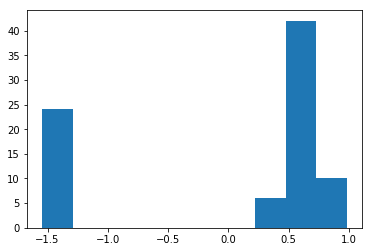

In [264]:
plt.hist((np.asarray(p11)-np.mean(p11))/np.std(p11))

In [120]:
red=[]
rec=[]
readallframes("C:/Users/gordon/Documents/5_a.bag",0,1000,red,rec)

In [121]:
len(red)

628

In [128]:
#critical=get_critiacal_frames(30,np.asarray([250,250,250]),np.asarray([255,255,255]),rec)
critical=140
p=rec[critical-5]
redstd=red[critical-7:critical-3]
mask =np.asarray([ red_mask(p)])+np.asarray([ green_mask(p)])
mask=(mask>0)
mask=np.moveaxis(mask,0,-1)
img= (p*mask).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imshow('My Image critical',cv2.cvtColor(rec[critical], cv2.COLOR_RGB2BGR))
cv2.imshow('My Image ori',cv2.cvtColor(rec[critical+0], cv2.COLOR_RGB2BGR))
cv2.imshow('My Image mask',img)

# 按下任意鍵則關閉所有視窗
cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Users\gordon\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\gordon\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\gordon\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\gordon\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [28]:
len(red[::10])

67

In [175]:
bg=getbackground(red[::5])

In [179]:
def NON_BG_MASK(bg,frame):
    mask=bg-frame
    return  mask>8*(0.000006*frame*frame+0.0002*frame)

In [180]:
need=non_zero_mean(red[critical-1:critical+1])
allpoints=savetopointcloud("low_light.ply",need*NON_BG_MASK(bg,need),rec[critical],re=True)
print(len(allpoints))
point_after_transform=points_transform((ans1-ans2),(ans3-ans4),Normalvector,(ans1+ans2)/2,allpoints[:,0:3])
point_after_transform_new =[]
allcolor=[]
for  i in range(len(point_after_transform)):
    if(np.linalg.norm(point_after_transform[i])<4000):
        point_after_transform_new.append(point_after_transform[i])
        allcolor.append(allpoints[i,3:6])
savepointtofile(np.concatenate((point_after_transform_new,allcolor),axis=1),"stdpoints10.ply")

C:\Users\gordon\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


161764


In [267]:
not_bg=np.logical_and((bg>red),np.asarray(red)>0)*255
not_bg

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [271]:
cv2.namedWindow("Color Stream 2", cv2.WINDOW_AUTOSIZE)
for i in range(not_bg.shape[0]):
    cv2.imshow("Color Stream 2",not_bg[i].astype("uint8"))
    #cv2.imshow("Depth Stream", depth_color_image)
    cv2.waitKey(30)
cv2.destroyAllWindows()

In [269]:
not_bg[68].astype(np.uint8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [270]:
num_labels, labels_im = cv2.connectedComponents(not_bg[68].astype(np.uint8))
count=np.zeros(25)
for i in range(labels_im.):
    

SyntaxError: invalid syntax (<ipython-input-270-f29aa5d04323>, line 3)

In [ ]:
def find_continue_ball(notbg,dframes,cframes):
    for i in range(notbg.shape[0]):
        num_labels, labels_im = cv2.connectedComponents(notbg[i])
        

In [ ]:
 cv2.destroyAllWindows()

In [ ]:
class connect_green_plane_red_dot():
    def __init__(self,greenplane,reddot):
        if(greenplane.shape !=reddot.shape):
            raise Exception('shape dont match !!!!!')
        self.gp=greenplane
        self.rd=reddot
        self.mask=np.zero(self.gp.shape)
        self.record=[]
    def scanAll(self):
    def bfsOneObj(self,i,j):
    


In [7]:
n=14
k=2
(5+k)*(4+k)*(3+k)*(2+k)*(1+k)/n/(n-1)/(n-2)/(n-3)/(n-4)

0.010489510489510492

In [8]:
5*4*3/2*((7/16)**4)/8

0.13738632202148438